# Quantization In‑Depth — Part1

## 1. Why Quantize?

Quantization **reduces the numerical precision** of a model’s parameters and/or activations (e.g. from `float32` to `int8`).  
This offers:

* **Smaller models** ➜ lower storage & memory‑footprint, easier distribution.  
* **Faster inference** ➜ lower memory‑bandwidth + integer GEMM kernels.  
* **Lower power consumption** ➜ crucial for edge / mobile hardware.  

The Hugging Face *Quantization In‑Depth* course explores:  

1. Linear symmetric & asymmetric mode, per‑tensor, per‑channel and per-group quantization.  
2. Building a custom **8‑bit linear quantizer** from scratch.  
3. Practical challenges: weight packing, calibration, accuracy drop, hardware support.  
4. State‑of‑the‑art methods for compressing **large language models (LLMs)** beyond linear quantization.  

**Forward mapping**

$$
r = s\,(q - z)
$$

* **`r`** – high-precision (real-valued) tensor element  
* **`q`** – low-precision (integer) quantized value  
* **`s`** – *scale* (same dtype as `r`, e.g. `float32`)  
* **`z`** – *zero-point* offset (same dtype as `q`, e.g. `int8`)  

**Inverse mapping**

$$
q = \operatorname{clip} \!\bigl(\bigl\lfloor \tfrac{r}{s} + z \bigr\rceil,\; q_{\min},\, q_{\max}\bigr)
$$

where $q_{\min}$ and $q_{\max}$ are determined by the target integer dtype (e.g. −128 … 127 for signed `int8`).

The goal is to choose `s` and `z` so that *all* real values fall inside `[q_min, q_max]` and the dynamic range is used efficiently.


In [1]:
# Needed torch, suggested version:
#!pip install torch==2.1.1
#!pip install seaborn matplotlib

# Core imports
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap



In [2]:
def linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype=torch.int8):
    """Quantize `tensor` to `dtype` using pre‑computed `scale` and `zero_point`."""
    # Scale and shift
    scaled = tensor / scale + zero_point
    rounded_tensor = torch.round(scaled)
    # Compute quantized range
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    # Clip rounded values to quantized range
    return rounded_tensor.clamp(q_min, q_max).to(dtype)


In [3]:
# Example tensor
test_tensor = torch.tensor(
    [[191.6, -13.5, 728.6],
     [92.14, 295.5, -184.0],
     [0.0,   684.6, 245.5]]
)
test_tensor


tensor([[ 191.6000,  -13.5000,  728.6000],
        [  92.1400,  295.5000, -184.0000],
        [   0.0000,  684.6000,  245.5000]])

### Choosing `scale` and `zero_point`

For **per‑tensor** PTQ we map extremes to the integer range:

\[
\begin{aligned}
s &= \frac{r_{\max} - r_{\min}}{q_{\max} - q_{\min}} \\
z &= \operatorname{round}\bigl(q_{\min} - \tfrac{r_{\min}}{s}\bigr)
\end{aligned}
\]

and clip `z` into `[q_min, q_max]`.

In [4]:
def get_q_scale_and_zero_point(tensor, dtype=torch.int8):
    """Get scale and zero point for quantization."""
    # Compute quantized range
    q_min, q_max = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    r_min, r_max = tensor.min().item(), tensor.max().item()
    # Compute scale and zero point
    scale = (r_max - r_min) / float(q_max - q_min)
    zero_point = q_min - r_min / scale
    # Round & clip
    zero_point = int(round(zero_point))
    zero_point = max(q_min, min(q_max, zero_point))
    return scale, zero_point

scale, zero_point = get_q_scale_and_zero_point(test_tensor)
scale, zero_point


(3.578823433670343, -77)

In [5]:
def linear_dequantization(q_tensor, scale, zero_point):
    return scale * (q_tensor.float() - zero_point)


In [6]:
q_tensor = linear_q_with_scale_and_zero_point(test_tensor, scale, zero_point)
dq_tensor = linear_dequantization(q_tensor, scale, zero_point)
mse = (dq_tensor - test_tensor).square().mean()
print("Quantized tensor:\n", q_tensor)
print("\nDe‑quantized tensor:\n", dq_tensor)
print(f"Mean‑squared‑error: {mse:.4f}")


Quantized tensor:
 tensor([[ -23,  -81,  127],
        [ -51,    6, -128],
        [ -77,  114,   -8]], dtype=torch.int8)

De‑quantized tensor:
 tensor([[ 193.2565,  -14.3153,  730.0800],
        [  93.0494,  297.0423, -182.5200],
        [   0.0000,  683.5552,  246.9388]])
Mean‑squared‑error: 1.5730


In [7]:
# Helper utilities for visualising quantization error
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

def _plot_matrix(t, ax, title, vmin=None, vmax=None, cmap=None):
    sns.heatmap(t.cpu().numpy(), ax=ax, vmin=vmin, vmax=vmax,
                cmap=cmap, annot=True, fmt=".2f", cbar=False)
    ax.set_title(title)
    ax.set_xticklabels([])
    ax.set_yticklabels([])

def plot_quantization_errors(original, quantized, dequantized, dtype=torch.int8):
    fig, axes = plt.subplots(1, 4, figsize=(15,4))
    _plot_matrix(original, axes[0], "Original", cmap=ListedColormap(['white']))
    qmin, qmax = torch.iinfo(dtype).min, torch.iinfo(dtype).max
    _plot_matrix(quantized, axes[1], "Quantized", vmin=qmin, vmax=qmax, cmap='coolwarm')
    _plot_matrix(dequantized, axes[2], "De‑quantized", cmap='coolwarm')
    err = (original - dequantized).abs()
    _plot_matrix(err, axes[3], "Abs Error", cmap=ListedColormap(['white']))
    fig.tight_layout()
    plt.show()


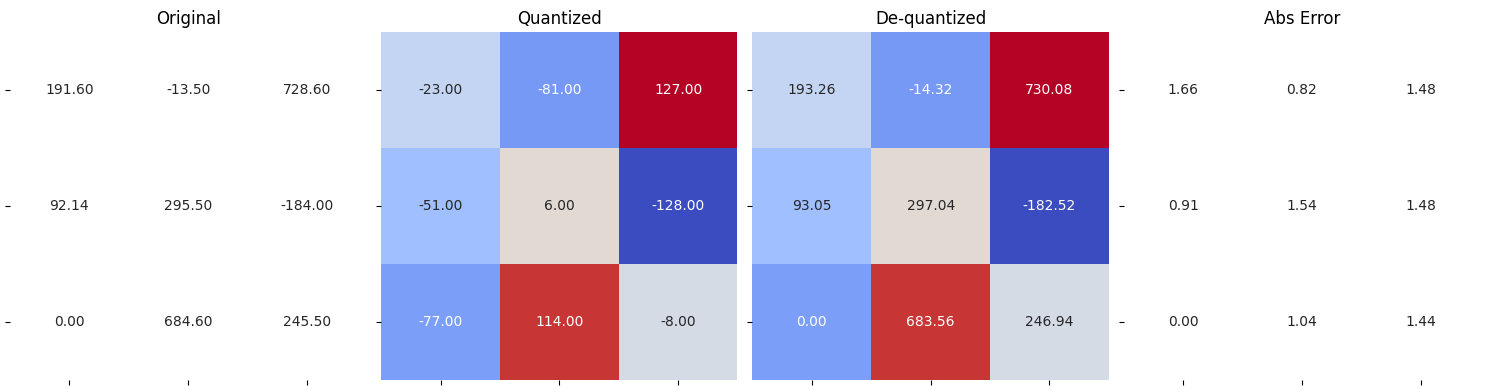

In [8]:
# Visualise errors
plot_quantization_errors(test_tensor, q_tensor, dq_tensor)


### One‑liner helper

In [9]:
def linear_quantization(tensor, dtype=torch.int8):
    scale, zero_point = get_q_scale_and_zero_point(tensor, dtype)
    q_tensor = linear_q_with_scale_and_zero_point(tensor, scale, zero_point, dtype)
    return q_tensor, scale, zero_point


In [10]:
r_tensor = torch.randn((4, 4))

In [11]:
quantized_tensor, scale, zero_point = linear_quantization(r_tensor)
dequantized_tensor = linear_dequantization(quantized_tensor,
                                           scale, zero_point)

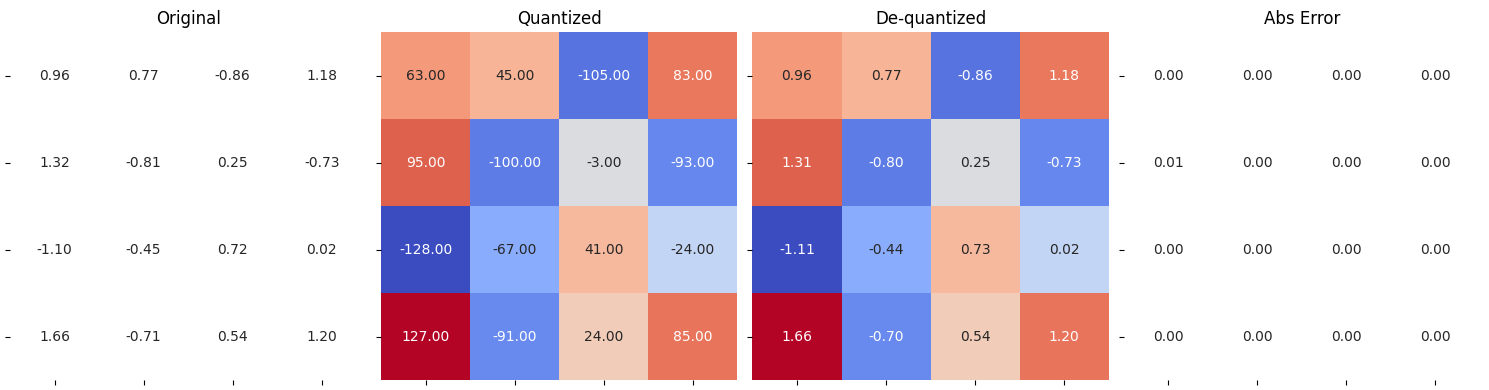

In [12]:
plot_quantization_errors(r_tensor, quantized_tensor,
                         dequantized_tensor)

In [13]:
print((dequantized_tensor-r_tensor).square().mean().item())

1.1233577424718533e-05
